In [1]:
!pip install timm
! pip install --upgrade sympy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 72.6 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: Operation cancelled by user
^C


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import copy
from statistics import mean
from dataclasses import dataclass, field
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
import requests
import zipfile
from io import BytesIO
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import timm
import random

In [2]:
# Define the URL of the zipped dataset
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip'

# Send a GET request to download the zip file
response = requests.get(url)

# Check if the download was successful
if response.status_code == 200:
    print("✅ Download completed!")

    # Extract the ZIP file directly from memory
    with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
        # List all files inside the ZIP archive
        file_list = zip_ref.namelist()
        print(f"📦 Files inside the ZIP: {file_list}")

        # Define the extraction directory
        extract_path = "Dataset"
        os.makedirs(extract_path, exist_ok=True)

        # Extract all files
        zip_ref.extractall(extract_path)
        print(f"📂 Files extracted to directory: {extract_path}")
else:
    print(f"❌ Failed to download dataset. Status code: {response.status_code}")
    raise SystemExit()

# Verify that all expected files were extracted
extracted_files_flat = []
for root, _, files in os.walk(extract_path):
    for file in files:
        relative_path = os.path.relpath(os.path.join(root, file), extract_path)
        extracted_files_flat.append(relative_path.replace("\\", "/"))  # Normalize path

# Compare file lists
if set(file_list) == set(extracted_files_flat):
    print("✅ All files have been successfully extracted.")
else:
    missing_files = set(file_list) - set(extracted_files_flat)
    print(f"⚠️ Missing files detected: {missing_files}")

    # Re-extract missing files
    with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
        for missing_file in missing_files:
            zip_ref.extract(missing_file, extract_path)
            print(f"🔄 Re-extracted missing file: {missing_file}")

    print("✅ All files have been successfully extracted after recheck.")

print("🎉 Operation completed.")


✅ Download completed!
📦 Files inside the ZIP: ['dataset/', '__MACOSX/._dataset', 'dataset/test/', 'dataset/train/', 'dataset/val/', 'dataset/test/Sandwich/', 'dataset/test/ice_cream/', 'dataset/test/chicken_curry/', 'dataset/test/Donut/', 'dataset/test/cheesecake/', 'dataset/test/Crispy Chicken/', 'dataset/test/Baked Potato/', 'dataset/test/apple_pie/', 'dataset/test/Fries/', 'dataset/test/omelette/', 'dataset/test/sushi/', 'dataset/test/Hot Dog/', 'dataset/test/Taquito/', 'dataset/test/Taco/', 'dataset/train/Sandwich/', 'dataset/train/ice_cream/', 'dataset/train/chicken_curry/', 'dataset/train/Donut/', 'dataset/train/cheesecake/', 'dataset/train/Crispy Chicken/', 'dataset/train/Baked Potato/', 'dataset/train/apple_pie/', 'dataset/train/Fries/', 'dataset/train/omelette/', 'dataset/train/sushi/', 'dataset/train/Hot Dog/', 'dataset/train/Taquito/', 'dataset/train/Taco/', 'dataset/val/Sandwich/', 'dataset/val/ice_cream/', 'dataset/val/chicken_curry/', 'dataset/val/Donut/', 'dataset/val/ch

In [3]:
# Controllo se nel dataset ci sono immagini corrotte con una apposita funzione
def check_corrupted_images(directory):
    corrupted_images = []


    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:

                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Immagine corrotta rilevata: {file_path}")
                corrupted_images.append(file_path)

    if not corrupted_images:
        print("Nessuna immagine corrotta trovata.")
    else:
        print(f"Immagini corrotte: {corrupted_images}")

# Eseguo  il comando di controllo delle immagini corrotte
extract_path = "/content/Dataset/dataset"
check_corrupted_images(extract_path)

Nessuna immagine corrotta trovata.


In [4]:
# Define a function to check for corrupted images in the dataset
def check_corrupted_images(directory):
    corrupted_images = []  # List to store paths of corrupted images

    # Walk through all files in the specified directory and its subdirectories
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Attempt to open and verify the image
                with Image.open(file_path) as img:
                    img.verify()  # Does not load the image, only verifies integrity
            except (IOError, SyntaxError) as e:
                # If an error is raised, the image is likely corrupted
                print(f"Corrupted image detected: {file_path}")
                corrupted_images.append(file_path)

    # Print summary of results
    if not corrupted_images:
        print("No corrupted images found.")
    else:
        print(f"Corrupted images: {corrupted_images}")

# Run the corrupted image check on the extracted dataset directory
extract_path = "/content/Dataset/dataset"
check_corrupted_images(extract_path)

No corrupted images found.


In [5]:
# Define a function to compute dataset statistics (per split: train, val, test)
def calculate_dataset_statistics(data_dir):
    categories = ['train', 'val', 'test']

    # Initialize a dictionary to store statistics for each dataset split
    statistics = {category: {
        'count': 0,
        'total_width': 0,
        'total_height': 0,
        'total_pixel_count': 0,
        'formats': set(),
        'channels': set(),
        'low_brightness_count': 0,
        'low_resolution_count': 0
    } for category in categories}

    # Threshold parameters
    brightness_threshold = 50  # Average brightness below which an image is considered "low brightness"
    low_resolution_threshold = (256, 256)  # Minimum resolution to be considered "acceptable"

    # Loop through each dataset split
    for category in categories:
        category_dir = os.path.join(data_dir, category)

        if not os.path.exists(category_dir):
            print(f"Directory not found: {category_dir}")
            continue

        # Iterate through each class folder within the category
        classes = os.listdir(category_dir)
        for cls in classes:
            class_dir = os.path.join(category_dir, cls)
            if not os.path.isdir(class_dir):
                continue

            images = os.listdir(class_dir)

            for img_name in images:
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        # Get image dimensions and format
                        width, height = img.size
                        img_format = img.format.lower()  # Example: jpg, png
                        mode = img.mode

                        # Update general statistics
                        statistics[category]['count'] += 1
                        statistics[category]['total_width'] += width
                        statistics[category]['total_height'] += height
                        statistics[category]['total_pixel_count'] += width * height
                        statistics[category]['formats'].add(img_format)
                        statistics[category]['channels'].add(len(img.getbands()))

                        # Convert image to grayscale to compute brightness
                        grayscale_img = img.convert("L")
                        avg_brightness = np.mean(np.array(grayscale_img))

                        # Check for low brightness
                        if avg_brightness < brightness_threshold:
                            statistics[category]['low_brightness_count'] += 1

                        # Check for low resolution
                        if width < low_resolution_threshold[0] or height < low_resolution_threshold[1]:
                            statistics[category]['low_resolution_count'] += 1

                except Exception as e:
                    print(f"Error opening image {img_name}: {e}")

        # Calculate and print average statistics for the current dataset split
        count = statistics[category]['count']
        if count > 0:
            avg_width = statistics[category]['total_width'] / count
            avg_height = statistics[category]['total_height'] / count
            avg_pixel_count = statistics[category]['total_pixel_count'] / count

            print(f"\nStatistics for {category} set:\n")
            print(f"  Total number of images: {count}")
            print(f"  Average image size: {avg_width:.2f} x {avg_height:.2f}")
            print(f"  Average pixel count per image: {avg_pixel_count:.2f}")
            print(f"  Image formats: {', '.join(statistics[category]['formats'])}")
            print(f"  Number of channels: {max(statistics[category]['channels'])}")
            print(f"  Low brightness images: {statistics[category]['low_brightness_count']}")
            print(f"  Low resolution images: {statistics[category]['low_resolution_count']}\n")

# Define the path to the root dataset directory
data_dir = '/content/Dataset/dataset'  # Modify this if using a different path

# Execute the statistics function
calculate_dataset_statistics(data_dir)


Statistics for train set:

  Total number of images: 8960
  Average image size: 512.00 x 512.00
  Average pixel count per image: 262144.00
  Image formats: png, jpeg
  Number of channels: 3
  Low brightness images: 51
  Low resolution images: 0


Statistics for val set:

  Total number of images: 2240
  Average image size: 512.00 x 512.00
  Average pixel count per image: 262144.00
  Image formats: png, jpeg
  Number of channels: 3
  Low brightness images: 5
  Low resolution images: 0


Statistics for test set:

  Total number of images: 2800
  Average image size: 512.00 x 512.00
  Average pixel count per image: 262144.00
  Image formats: png, jpeg
  Number of channels: 3
  Low brightness images: 16
  Low resolution images: 0




Displaying random images from the train set:


<Figure size 1500x1000 with 0 Axes>

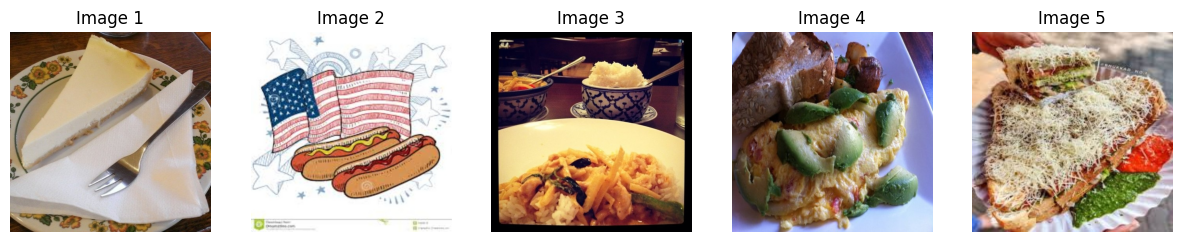


Displaying random images from the validation set:


<Figure size 1500x1000 with 0 Axes>

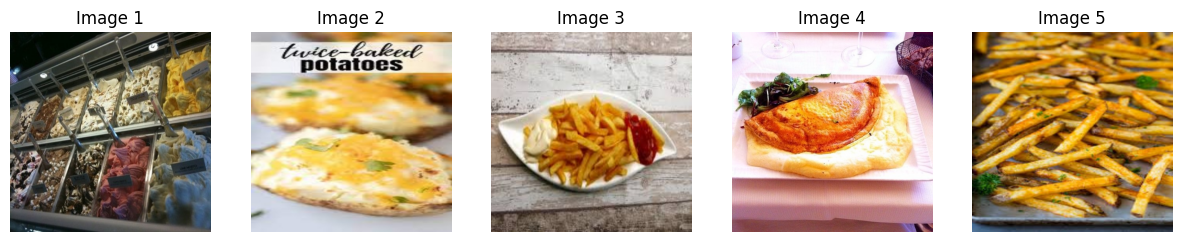


Displaying random images from the test set:


<Figure size 1500x1000 with 0 Axes>

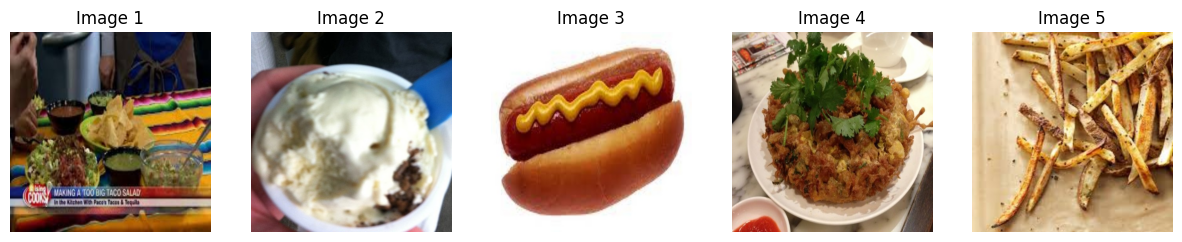

In [6]:
# Define a function to visualize random images from a specific dataset split
def visualize_random_images(data_dir, category, num_images=5):
    category_dir = os.path.join(data_dir, category)

    # Check if the directory exists
    if not os.path.exists(category_dir):
        print(f"Directory not found: {category_dir}")
        return

    images = []
    # Walk through all class subdirectories and collect valid image files
    for root, _, files in os.walk(category_dir):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg', 'bmp')):
                images.append(os.path.join(root, file))

    # If images are found, sample a few randomly and display them
    if len(images) > 0:
        random_images = random.sample(images, min(len(images), num_images))

        # Set up the matplotlib figure
        fig, axes = plt.subplots(1, len(random_images), figsize=(15, 5))

        for i, img_path in enumerate(random_images):
            try:
                with Image.open(img_path) as img:
                    ax = axes[i]
                    ax.imshow(img)
                    ax.axis('off')  # Hide axis
                    ax.set_title(f"Image {i+1}")
            except Exception as e:
                print(f"Error opening image: {e}")
    else:
        print(f"No images found in directory {category_dir}")

# Set your dataset path
data_dir = '/content/Dataset/dataset'  # Modify this if your path differs

# Display 5 random images for each dataset split (train, val, test)
plt.figure(figsize=(15, 10))
print("\nDisplaying random images from the train set:")
visualize_random_images(data_dir, 'train', num_images=5)
plt.show()

plt.figure(figsize=(15, 10))
print("\nDisplaying random images from the validation set:")
visualize_random_images(data_dir, 'val', num_images=5)
plt.show()

plt.figure(figsize=(15, 10))
print("\nDisplaying random images from the test set:")
visualize_random_images(data_dir, 'test', num_images=5)
plt.show()

In [7]:
"The images appear to be of high quality, and based on this random sample, there are no signs of corruption or significant anomalies."

'The images appear to be of high quality, and based on this random sample, there are no signs of corruption or significant anomalies.'

Train dataset size: 8960
Validation dataset size: 2240
Test dataset size: 2800


Batch image dimensions: torch.Size([32, 3, 224, 224])
Batch labels: tensor([ 6,  5,  4,  2,  3,  5, 10,  6,  5,  6,  1, 10,  1,  2,  2,  3,  9, 11,
         9,  1,  5,  8,  0,  3,  1, 13,  0,  3,  9,  3, 13,  5])


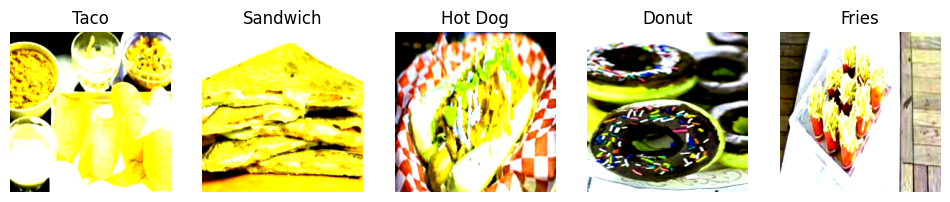

In [8]:
# Define the main path to the dataset
data_dir = '/content/Dataset/dataset'

# Define image transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color variation
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # Normalize using ImageNet mean
                         (0.229, 0.224, 0.225))  # and standard deviation
])

# Load datasets with applied transformations
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes to verify correct loading
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# Define a function to display a batch of images with labels
def show_images(images, labels, class_names):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 12))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        img = img / 2 + 0.5  # Unnormalize to bring pixel values back to [0, 1]
        np_img = img.numpy()
        axes[i].imshow(np.transpose(np_img, (1, 2, 0)))  # Convert tensor to image format
        axes[i].set_title(class_names[lbl])
        axes[i].axis('off')
    plt.show()

# Fetch one batch of training images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f'Batch image dimensions: {images.size()}')
print(f'Batch labels: {labels}')

# Display first 5 images from the batch
class_names = train_dataset.classes
show_images(images[:5], labels[:5], class_names)

In [9]:
# Explore the dataset: number of classes and class names for each split

# Print number of classes and class names in the training set
print("Number of training classes:", len(train_dataset.classes))
print("Training classes:", train_dataset.classes)

# Print class names and number of classes in the validation set
print("Validation classes:", val_dataset.classes)
print("Number of validation classes:", len(val_dataset.classes))

# Print class names and number of classes in the test set
print("Test classes:", test_dataset.classes)
print("Number of test classes:", len(test_dataset.classes))

Number of training classes: 14
Training classes: ['Baked Potato', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Sandwich', 'Taco', 'Taquito', 'apple_pie', 'cheesecake', 'chicken_curry', 'ice_cream', 'omelette', 'sushi']
Validation classes: ['Baked Potato', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Sandwich', 'Taco', 'Taquito', 'apple_pie', 'cheesecake', 'chicken_curry', 'ice_cream', 'omelette', 'sushi']
Number of validation classes: 14
Test classes: ['Baked Potato', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Sandwich', 'Taco', 'Taquito', 'apple_pie', 'cheesecake', 'chicken_curry', 'ice_cream', 'omelette', 'sushi']
Number of test classes: 14


In [10]:
# Define dataset split paths
train_path = '/content/Dataset/dataset/train'
val_path = '/content/Dataset/dataset/val'
test_path = '/content/Dataset/dataset/test'

# Define a function to count the number of images per class in a given directory
def count_images_in_directory(directory_path):
    counts = {}
    for class_name in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_name)
        if os.path.isdir(class_path):
            # Count only files with .jpeg or .jpg extensions
            num_images = len([name for name in os.listdir(class_path)
                              if name.endswith('.jpeg') or name.endswith('.jpg')])
            counts[class_name] = num_images
    return counts

# Apply the function to each dataset split
train_counts = count_images_in_directory(train_path)
val_counts = count_images_in_directory(val_path)
test_counts = count_images_in_directory(test_path)

# Print the results
print("Train set image counts per class:", train_counts)
print("Validation set image counts per class:", val_counts)
print("Test set image counts per class:", test_counts)

Train set image counts per class: {'chicken_curry': 640, 'sushi': 640, 'ice_cream': 640, 'Taquito': 640, 'Taco': 640, 'Crispy Chicken': 640, 'Donut': 635, 'apple_pie': 640, 'Sandwich': 640, 'cheesecake': 640, 'Hot Dog': 629, 'Fries': 640, 'Baked Potato': 640, 'omelette': 640}
Validation set image counts per class: {'chicken_curry': 160, 'sushi': 160, 'ice_cream': 160, 'Taquito': 160, 'Taco': 160, 'Crispy Chicken': 160, 'Donut': 158, 'apple_pie': 160, 'Sandwich': 160, 'cheesecake': 160, 'Hot Dog': 160, 'Fries': 160, 'Baked Potato': 160, 'omelette': 160}
Test set image counts per class: {'chicken_curry': 200, 'sushi': 200, 'ice_cream': 200, 'Taquito': 200, 'Taco': 200, 'Crispy Chicken': 200, 'Donut': 196, 'apple_pie': 200, 'Sandwich': 200, 'cheesecake': 200, 'Hot Dog': 196, 'Fries': 200, 'Baked Potato': 200, 'omelette': 200}


In [11]:
"Overall, the dataset appears to be well-distributed and ready for training a neural network."

'Overall, the dataset appears to be well-distributed and ready for training a neural network.'

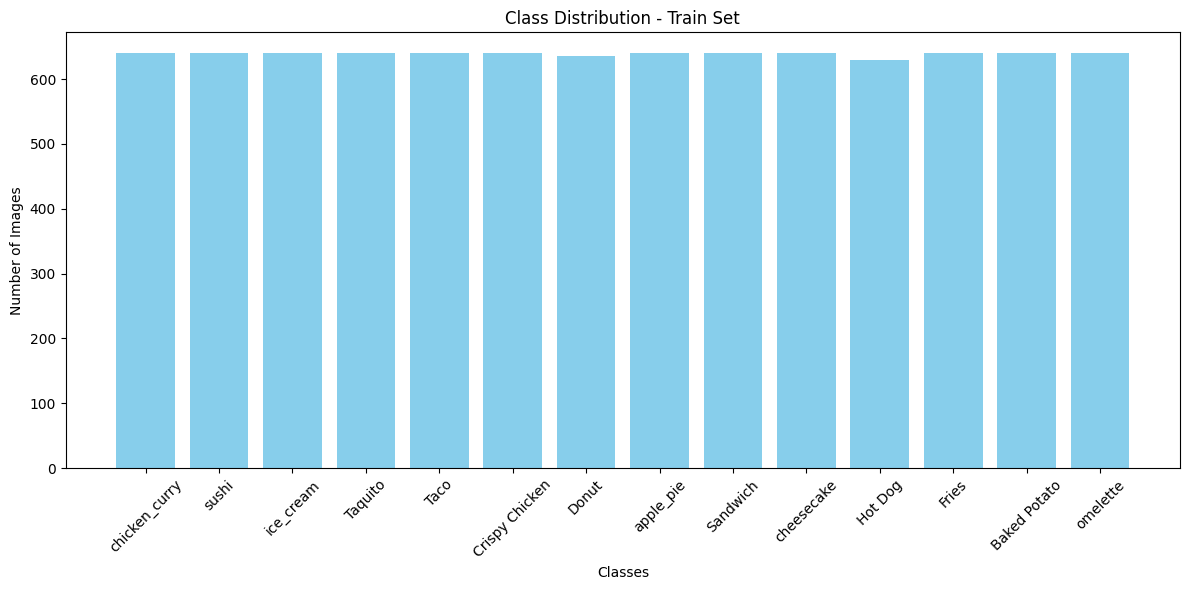

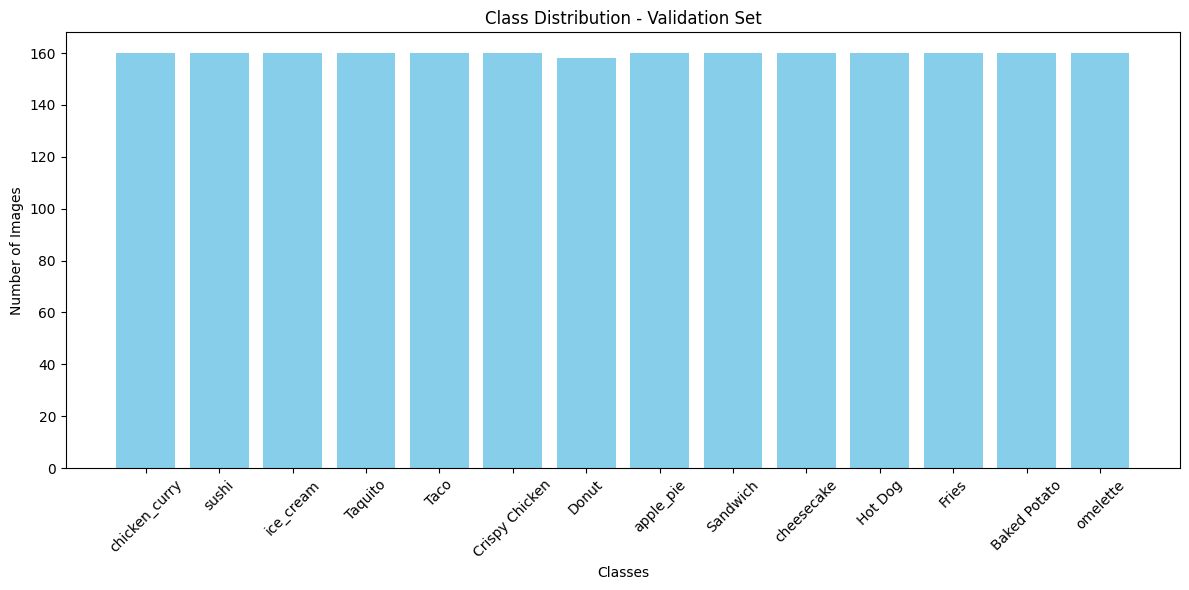

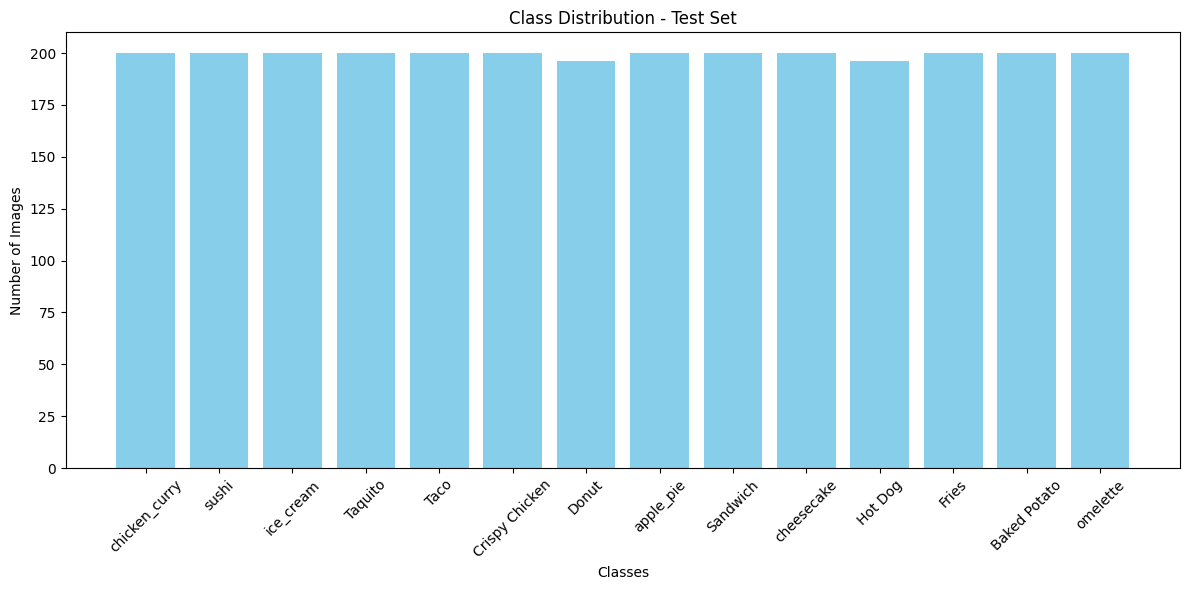

In [12]:
# Define a function to plot the class distribution using a bar chart
def plot_class_distribution(counts, title):
    classes = list(counts.keys())
    num_images = list(counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, num_images, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 🔍 Visualize the class distribution to check for balance across the dataset splits
plot_class_distribution(train_counts, 'Class Distribution - Train Set')
plot_class_distribution(val_counts, 'Class Distribution - Validation Set')
plot_class_distribution(test_counts, 'Class Distribution - Test Set')



In [13]:
"The train, validation, and test sets have been split in a balanced manner, each containing a similar number of images per class."

'The train, validation, and test sets have been split in a balanced manner, each containing a similar number of images per class.'

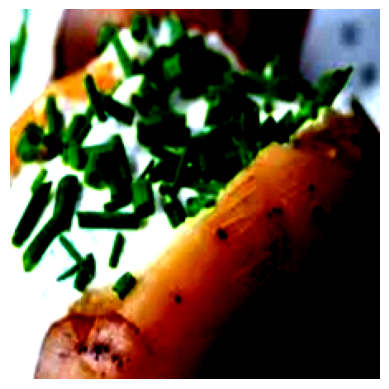

Label: Baked Potato


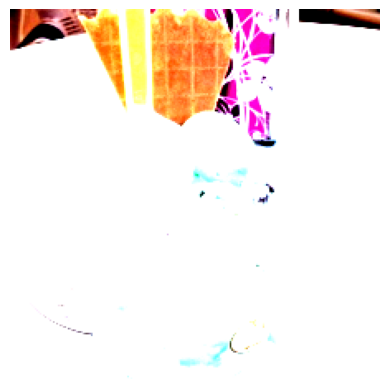

Label: ice_cream


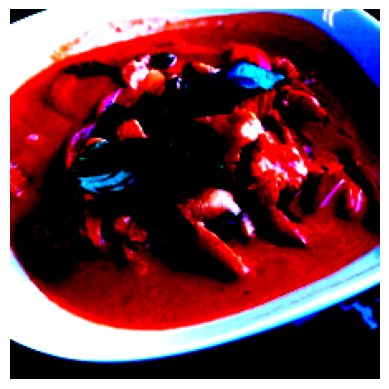

Label: chicken_curry


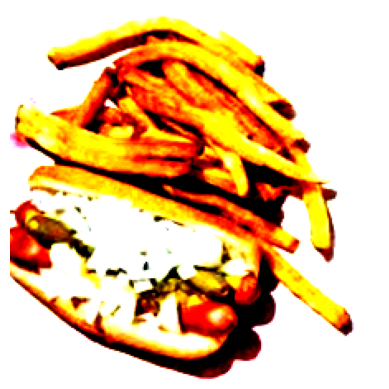

Label: Hot Dog


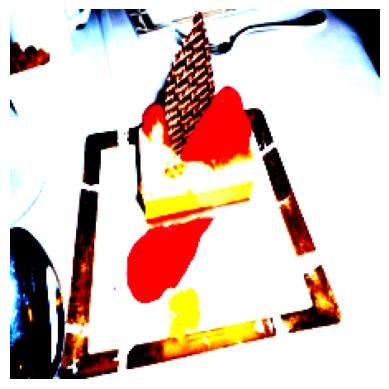

Label: cheesecake


In [14]:
# Define a utility function to visualize images after DataLoader transformations
def imshow(img):
    np_img = img.numpy()
    # Transpose the image from [C, H, W] to [H, W, C] format
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Fetch a batch of images and labels from the training DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first 5 transformed images with their corresponding class labels
for i in range(5):
    imshow(images[i])  # Display the image
    label_name = class_names[labels[i].item()]  # Get class name from label index
    print(f'Label: {label_name}')

In [15]:
# Proceeding to build a neural network model using PyTorch and leveraging GPU acceleration
#to develop an effective image recognition system.

# Define computation device: GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained EfficientNet (b0 variant) for transfer learning
model = timm.create_model('efficientnet_b0', pretrained=True)

# Determine the number of classes from the training dataset
num_classes = len(train_dataset.classes)

# Replace the final classification layer to match the number of target classes
if hasattr(model, 'classifier'):
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
elif hasattr(model, 'fc'):  # For models with a 'fc' layer instead
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

# Move the model to the selected device (GPU or CPU)
model = model.to(device)

# Define loss function (CrossEntropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam) with learning rate set to 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary and dataset sizes for verification
print(f'Model structure:\n{model}')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Model structure:
EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [16]:
# Define a function to save the model checkpoint during training
def save_checkpoint(model, optimizer, epoch, val_loss, val_acc, y_true, y_pred, filename="best_model.pth"):
    # Generate classification report (as a dictionary) using scikit-learn
    report = classification_report(y_true, y_pred, output_dict=True)

    # Store model and optimizer state along with metadata
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'classification_report': report
    }

    # Save checkpoint to disk
    torch.save(checkpoint, filename)
    print(f'Model saved at epoch {epoch} with validation loss: {val_loss:.4f} and accuracy: {val_acc:.4f}')


# Define a function to load a previously saved checkpoint
def load_checkpoint(model, optimizer, filename="best_model.pth"):
    if os.path.exists(filename):
        # Load checkpoint from file
        checkpoint = torch.load(filename)

        # Restore model and optimizer states
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']

        print(f'Model loaded from checkpoint at epoch {start_epoch}')
        return model, optimizer, start_epoch
    else:
        print(f"No checkpoint found at {filename}. Starting from scratch.")
        return model, optimizer, 0

In [17]:
""" Create an EarlyStopping class to halt training if no improvement in validation loss is observed
 for a defined number of consecutive epochs (default: 5), with a minimum delta threshold."""

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        """
        Args:
            patience (int): Number of epochs to wait after last improvement.
            min_delta (float): Minimum change in validation loss to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Check if validation loss has improved.
        If not, increment counter. If no improvement for 'patience' epochs, trigger early stop.
        """
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered. No improvement for {self.patience} consecutive epochs.")
                self.early_stop = True

In [18]:
# Define the full training loop with early stopping and model checkpointing
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer,
                                    num_epochs=25, patience=5, checkpoint_path="best_model.pth"):
    # Initialize early stopping logic
    early_stopping = EarlyStopping(patience=patience)

    # Track the best model weights and metrics
    best_model_wts = model.state_dict()
    best_loss = np.inf
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # === Training phase ===
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # === Validation phase ===
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        y_true = []
        y_pred = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

        # Save checkpoint if validation loss improves
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            save_checkpoint(model, optimizer, epoch + 1, val_loss, val_acc, y_true, y_pred, checkpoint_path)

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            model.load_state_dict(best_model_wts)
            return model, train_losses, val_losses, val_accuracies

    # Load best model weights before returning
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_accuracies

In [19]:
# 🔁 Start model training with early stopping and checkpoint saving

best_model, train_losses, val_losses, val_accuracies = train_model_with_early_stopping(
    model,               # Neural network (EfficientNet with custom head)
    train_loader,        # DataLoader for training set
    val_loader,          # DataLoader for validation set
    criterion,           # Loss function (CrossEntropyLoss)
    optimizer,           # Optimizer (Adam)
    num_epochs=25,       # Maximum number of training epochs
    patience=5,          # Early stopping patience
    checkpoint_path="best_model.pth"  # File path to save the best model checkpoint
)

Epoch 1/25
----------
Train Loss: 0.9182, Accuracy: 0.7079
Validation Loss: 0.6771, Accuracy: 0.7848
Model saved at epoch 1 with validation loss: 0.6771 and accuracy: 0.7848
Epoch 2/25
----------
Train Loss: 0.5049, Accuracy: 0.8378
Validation Loss: 0.6586, Accuracy: 0.8018
Model saved at epoch 2 with validation loss: 0.6586 and accuracy: 0.8018
Epoch 3/25
----------
Train Loss: 0.4024, Accuracy: 0.8698
Validation Loss: 0.5999, Accuracy: 0.8210
Model saved at epoch 3 with validation loss: 0.5999 and accuracy: 0.8210
Epoch 4/25
----------
Train Loss: 0.3276, Accuracy: 0.8927
Validation Loss: 0.5716, Accuracy: 0.8281
Model saved at epoch 4 with validation loss: 0.5716 and accuracy: 0.8281
Epoch 5/25
----------
Train Loss: 0.2658, Accuracy: 0.9115
Validation Loss: 0.5984, Accuracy: 0.8210
Epoch 6/25
----------
Train Loss: 0.2392, Accuracy: 0.9201
Validation Loss: 0.5588, Accuracy: 0.8397
Model saved at epoch 6 with validation loss: 0.5588 and accuracy: 0.8397
Epoch 7/25
----------
Train L

                precision    recall  f1-score   support

  Baked Potato       0.81      0.92      0.86       200
Crispy Chicken       0.84      0.82      0.83       200
         Donut       0.89      0.92      0.91       200
         Fries       0.86      0.85      0.86       200
       Hot Dog       0.85      0.76      0.80       200
      Sandwich       0.89      0.77      0.82       200
          Taco       0.68      0.73      0.70       200
       Taquito       0.81      0.80      0.80       200
     apple_pie       0.69      0.81      0.75       200
    cheesecake       0.85      0.81      0.83       200
 chicken_curry       0.75      0.91      0.82       200
     ice_cream       0.89      0.72      0.80       200
      omelette       0.79      0.81      0.80       200
         sushi       0.95      0.82      0.88       200

      accuracy                           0.82      2800
     macro avg       0.83      0.82      0.82      2800
  weighted avg       0.83      0.82      0.82 

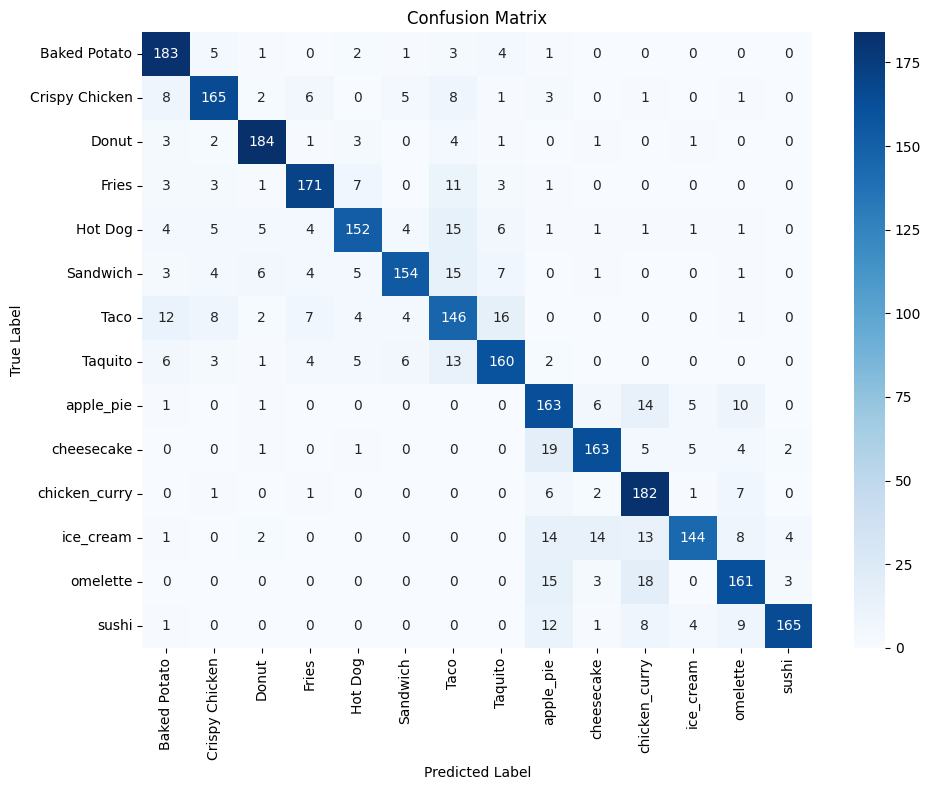

In [20]:
# 📊 Section: Evaluate final model performance and generate classification metrics

# Define a function to evaluate model predictions on a given dataset (e.g., test set)
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Define a function to visualize the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Run evaluation on the test set using the best saved model
all_preds, all_labels = evaluate_model(best_model, test_loader, device)

# Print detailed classification report (precision, recall, F1-score)
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Visualize confusion matrix for test set predictions
plot_confusion_matrix(all_labels, all_preds, train_dataset.classes)


In [21]:
"""Overall, the model achieves a solid accuracy of approximately 82%. However, it appears to struggle with the 'Taquito' class, which has around 641 instances.
It needs a preliminary investigation by visualizing some representative images from this class to better understand potential causes."""


"Overall, the model achieves a solid accuracy of approximately 82%. However, it appears to struggle with the 'Taquito' class, which has around 641 instances. \nIt needs a preliminary investigation by visualizing some representative images from this class to better understand potential causes."

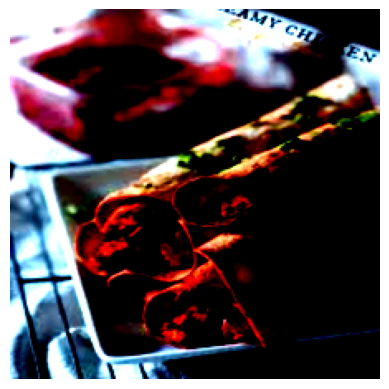

Label: Taquito


In [22]:
# Define a function to display an image tensor
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Rearrange dimensions from [C, H, W] to [H, W, C]
    plt.axis('off')  # Hide axis
    plt.show()

# Fetch a batch of images and labels from the train loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Get class names from dataset
class_names = train_dataset.classes

# Display up to 5 images belonging to the 'Taquito' class
target_class = 'Taquito'
max_images = 5
count = 0

# Check if the class exists
if target_class not in class_names:
    print(f"Class '{target_class}' not found in dataset.")
else:
    for i in range(len(images)):
        label_name = class_names[labels[i].item()]
        if label_name == target_class:
            imshow(images[i])  # Display the image
            print(f'Label: {label_name}')
            count += 1
            if count >= max_images:
                break

In [23]:
"""Visual inspection of the 'Taquito' class samples does not reveal significant issues in image quality or distinguishability.
To further improve model performance, we could reload the latest checkpoint and apply techniques such as Random Search for hyperparameter optimization
(e.g., learning rate, batch size), as well as Dropout to selectively deactivate neurons and prevent overfitting due to co-adaptation.
These strategies, combined with iterative checkpoint loading, could help accelerate training while improving generalization."""

"Visual inspection of the 'Taquito' class samples does not reveal significant issues in image quality or distinguishability. \nTo further improve model performance, we could reload the latest checkpoint and apply techniques such as Random Search for hyperparameter optimization \n(e.g., learning rate, batch size), as well as Dropout to selectively deactivate neurons and prevent overfitting due to co-adaptation. \nThese strategies, combined with iterative checkpoint loading, could help accelerate training while improving generalization."